### Question 1. 
Build and train a Perceptron (one input layer, one output layer, no hidden layers and no activation functions) to classify diabetes from the rest of the dataset. What is the AUC of this model?


In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.metrics import roc_auc_score

# Set random seed
np.random.seed(42)

# Load the data
df = pd.read_csv("diabetes.csv")
X = df.drop("Diabetes", axis=1)
y = df["Diabetes"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Perceptron model
perceptron = Perceptron(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'eta0': [0.001, 0.01, 0.1, 1.0],
    'max_iter': [500, 1000, 2000],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(perceptron, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the model with the best hyperparameters
best_perceptron = Perceptron(**best_params, random_state=42)
best_perceptron.fit(X_train, y_train)

# Make predictions and calculate AUC
y_pred = best_perceptron.predict(X_test)
auc = roc_auc_score(y_test, y_pred)

print(f"AUC: {auc:.4f}")


Best hyperparameters: {'eta0': 0.01, 'max_iter': 500}
AUC: 0.5013


In [33]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[43713,    26],
       [ 6975,    22]])

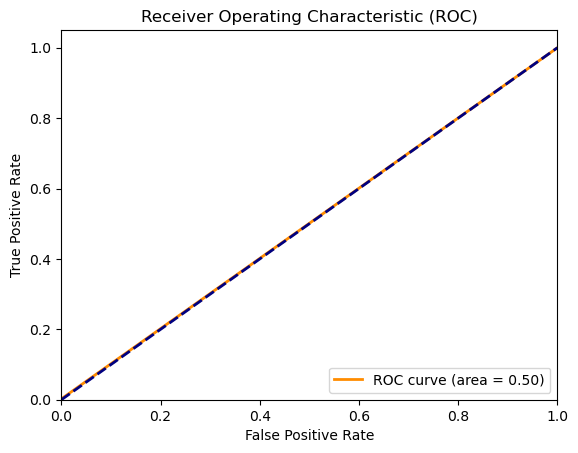

In [34]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

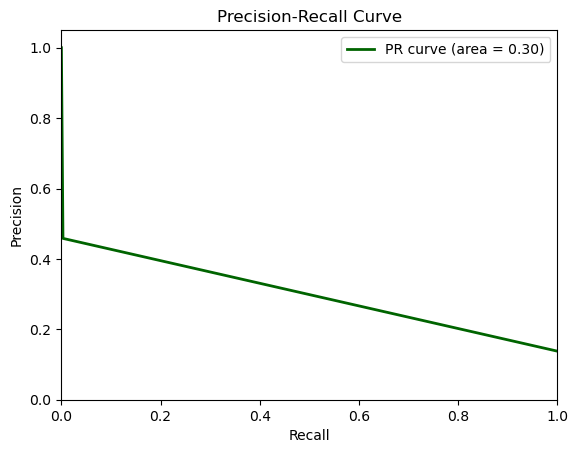

In [35]:
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkgreen', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

### Question 2.
Build and train a feedforward neural network with at least one hidden layer to classify diabetes from the rest of the dataset. Make sure to try different numbers of hidden layers and different activation functions (at a minimum reLU and sigmoid). Doing so: How does AUC vary as a function of the number of hidden layers and is it dependent on the kind of activation function used (make sure to include “no activation function” in your comparison). How does this network perform relative to the Perceptron?


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [39]:
# Define a function to train the model
def train_model(model, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Define a function to evaluate the model
def evaluate_model(model):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze().numpy()
        auc_score = roc_auc_score(y_test, y_pred)
    return auc_score

# Create different models with various hidden layers and activation functions
models = {
    "1_hidden_layer_ReLU": nn.Sequential(
        nn.Linear(X_train.shape[1], 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    ),
    "1_hidden_layer_Sigmoid": nn.Sequential(
        nn.Linear(X_train.shape[1], 16),
        nn.Sigmoid(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    ),
    # Add more models with different hidden layers and activation functions
}




In [40]:
# Train and evaluate each model
auc_scores = {}
for name, model in models.items():
    print(f"Training {name}...")
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, criterion, optimizer, num_epochs=100)
    auc_score = evaluate_model(model)
    auc_scores[name] = auc_score
    print(f"AUC: {auc_score}\n")

# Compare the AUC scores
print("AUC Scores:")
for name, score in auc_scores.items():
    print(f"{name}: {score}")

Training 1_hidden_layer_ReLU...
Epoch 10/100, Loss: 0.3135705933148686
Epoch 20/100, Loss: 0.3132408027396485
Epoch 30/100, Loss: 0.31300897469837485
Epoch 40/100, Loss: 0.31289651109306865
Epoch 50/100, Loss: 0.31287374674982543
Epoch 60/100, Loss: 0.3128158211454312
Epoch 70/100, Loss: 0.31265265367941614
Epoch 80/100, Loss: 0.31265618245389626
Epoch 90/100, Loss: 0.3126671648352577
Epoch 100/100, Loss: 0.3126206183914731
AUC: 0.8327722329339585

Training 1_hidden_layer_Sigmoid...
Epoch 10/100, Loss: 0.3142558556086481
Epoch 20/100, Loss: 0.31336928829809196
Epoch 30/100, Loss: 0.31303951809155156
Epoch 40/100, Loss: 0.31285634490733866
Epoch 50/100, Loss: 0.3126981437384838
Epoch 60/100, Loss: 0.31264661857285586
Epoch 70/100, Loss: 0.3125900608537063
Epoch 80/100, Loss: 0.3125076305411359
Epoch 90/100, Loss: 0.31242271249591647
Epoch 100/100, Loss: 0.31244818325140095
AUC: 0.832803220532799

AUC Scores:
1_hidden_layer_ReLU: 0.8327722329339585
1_hidden_layer_Sigmoid: 0.8328032205327

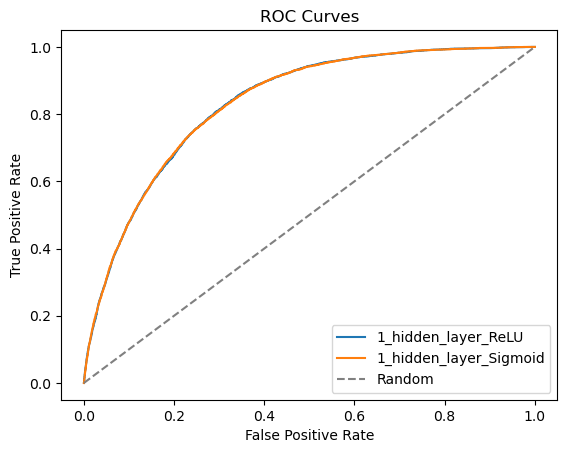

In [43]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Define a function to calculate FPR, TPR, and thresholds
def calculate_roc_curve(model):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze().numpy()
        fpr, tpr, _ = roc_curve(y_test, y_pred)
    return fpr, tpr

# Calculate ROC curves for each model and plot them
plt.figure()
for name, model in models.items():
    fpr, tpr = calculate_roc_curve(model)
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


### Question 3. 
Build and train a “deep” network (at least 2 hidden layers) to classify diabetes from the rest of the dataset. Given the nature of this dataset, is there a benefit of using a CNN or RNN for the classification?


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



In [52]:
# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [53]:
# Define the deep network with at least 2 hidden layers
class DeepNetwork(nn.Module):
    def __init__(self):
        super(DeepNetwork, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Train the model
model = DeepNetwork()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)



In [54]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_preds = model(X_test)

auc = roc_auc_score(y_test.numpy(), test_preds.numpy())
print(f"AUC: {auc}")


Epoch 10/100, Loss: 0.31421190986626535
Epoch 20/100, Loss: 0.3131422791518424
Epoch 30/100, Loss: 0.31254601017585204
Epoch 40/100, Loss: 0.31205572837799816
Epoch 50/100, Loss: 0.31161782055275555
Epoch 60/100, Loss: 0.31121778364570235
Epoch 70/100, Loss: 0.3108358903474065
Epoch 80/100, Loss: 0.3103870846441551
Epoch 90/100, Loss: 0.310027028790824
Epoch 100/100, Loss: 0.30964341662173317
AUC: 0.8327187761809636


/var/folders/vd/3bw01wbd4mj93f02vkyc8gn00000gn/T/ipykernel_56830/1206266004.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_prob_deep = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()


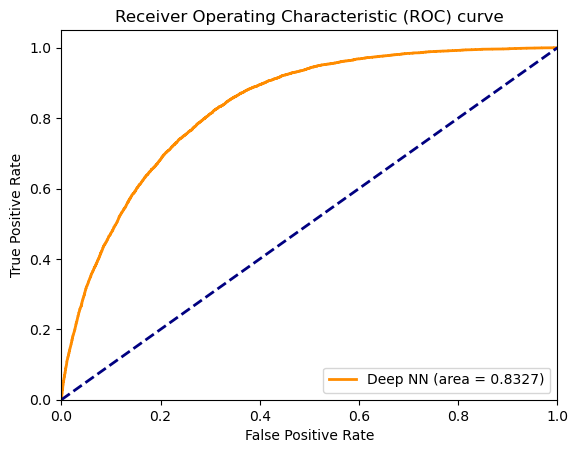

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Predict probabilities using the deep neural network model
y_prob_deep = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

# Calculate ROC curve and AUC
fpr_deep, tpr_deep, _ = roc_curve(y_test, y_prob_deep)
roc_auc_deep = auc(fpr_deep, tpr_deep)

# Calculate Precision-Recall curve and average precision
precision_deep, recall_deep, _ = precision_recall_curve(y_test, y_prob_deep)
average_precision_deep = average_precision_score(y_test, y_prob_deep)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr_deep, tpr_deep, color='darkorange', lw=lw, label='Deep NN (area = %0.4f)' % roc_auc_deep)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

#


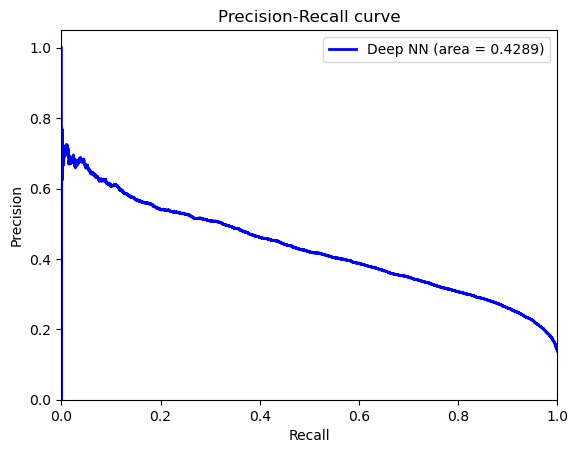

In [56]:
# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_deep, precision_deep, color='blue', lw=lw, label='Deep NN (area = %0.4f)' % average_precision_deep)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()

### Question 4. 
Build and train a feedforward neural network with one hidden layer to predict BMI from the rest of the dataset. Use RMSE to assess the accuracy of your model. Does the RMSE depend on the activation function used?


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data
data = df.drop(columns=['BMI'])
target = df['BMI']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)




In [60]:
# Define the model
class BMIModel(nn.Module):
    def __init__(self, input_size, hidden_size, activation_function):
        super(BMIModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation_function = activation_function

    def forward(self, x):
        x = self.activation_function(self.fc1(x))
        x = self.fc2(x)
        return x



In [61]:
# Train and evaluate the model
def train_and_evaluate_model(activation_function, epochs=100):
    input_size = X_train.shape[1]
    hidden_size = 64

    model = BMIModel(input_size, hidden_size, activation_function)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}')

    with torch.no_grad():
        y_pred = model(X_test.to(device)).cpu()
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f'RMSE: {rmse}')
        return rmse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}

rmse_scores = {}

for name, activation_function in activation_functions.items():
    print(f'Training with {name} activation function...')
    rmse_scores[name] = train_and_evaluate_model(activation_function)

Training with ReLU activation function...
Epoch 10/100, Loss: 37.02790666596441
Epoch 20/100, Loss: 36.810995730493616
Epoch 30/100, Loss: 36.74589428229499
Epoch 40/100, Loss: 36.7259030289471
Epoch 50/100, Loss: 36.70604069606621
Epoch 60/100, Loss: 36.67503709621664
Epoch 70/100, Loss: 36.657784576560374
Epoch 80/100, Loss: 36.64289002401977
Epoch 90/100, Loss: 36.64291751786987
Epoch 100/100, Loss: 36.6056799547261
RMSE: 6.086742401123047
Training with Sigmoid activation function...
Epoch 10/100, Loss: 35.991540938888356
Epoch 20/100, Loss: 35.802465401850675
Epoch 30/100, Loss: 35.706439837188384
Epoch 40/100, Loss: 35.65663172265627
Epoch 50/100, Loss: 35.61488606553091
Epoch 60/100, Loss: 35.5743684702512
Epoch 70/100, Loss: 35.53730594258472
Epoch 80/100, Loss: 35.49775853964554
Epoch 90/100, Loss: 35.470629083963644
Epoch 100/100, Loss: 35.45553946968735
RMSE: 5.987816333770752
Training with Tanh activation function...
Epoch 10/100, Loss: 35.93311430144032
Epoch 20/100, Loss: 

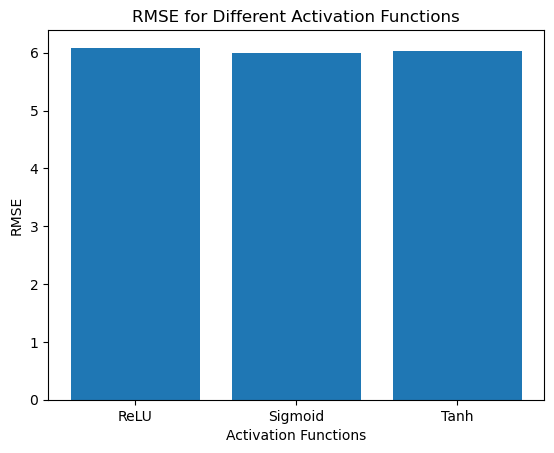

In [62]:
import matplotlib.pyplot as plt

def plot_rmse_scores(rmse_scores):
    activation_functions = list(rmse_scores.keys())
    rmse_values = list(rmse_scores.values())

    plt.bar(activation_functions, rmse_values)
    plt.xlabel('Activation Functions')
    plt.ylabel('RMSE')
    plt.title('RMSE for Different Activation Functions')
    plt.show()

plot_rmse_scores(rmse_scores)


### Question 5. 
Build and train a neural network of your choice to predict BMI from the rest of your dataset. How low can you get RMSE and what design choices does RMSE seem to depend on?


In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('diabetes.csv')

# Split into features and labels
X = df.drop('BMI', axis=1).values
y = df['BMI'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)



Epoch 10/100, Train Loss: 6.005266211745751, Test Loss: 5.98853028966097
Epoch 20/100, Train Loss: 5.992313678822858, Test Loss: 5.98009253020338
Epoch 30/100, Train Loss: 5.986831220176109, Test Loss: 5.984592311360003
Epoch 40/100, Train Loss: 5.981174420250753, Test Loss: 5.979924603224947
Epoch 50/100, Train Loss: 5.9780494781857145, Test Loss: 5.9743854276457835
Epoch 60/100, Train Loss: 5.977199506505068, Test Loss: 5.973565665180455
Epoch 70/100, Train Loss: 5.97562121484258, Test Loss: 5.9763257095536915
Epoch 80/100, Train Loss: 5.973376073781035, Test Loss: 5.993614940998703
Epoch 90/100, Train Loss: 5.973034963402573, Test Loss: 5.9717825806650096
Epoch 100/100, Train Loss: 5.972254986676261, Test Loss: 5.978969040975822


<function matplotlib.pyplot.legend(*args, **kwargs)>

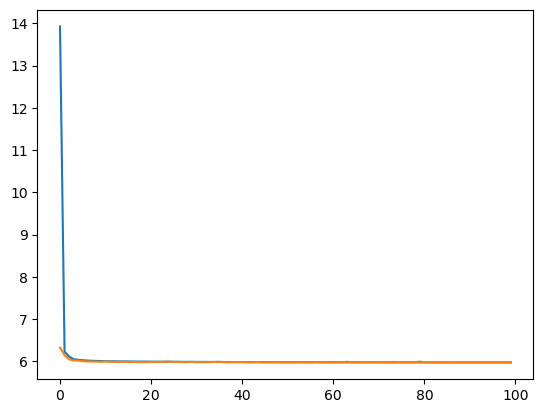

In [88]:
# Define the model architecture
class Net(nn.Module):

    def __init__(self, num_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 16)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        return x

num_features = X_train.shape[1]
model = Net(num_features)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the model
epochs = 100
train_losses = []
test_losses = []
for epoch in range(epochs):
    # Training
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*inputs.size(0)
    train_loss = np.sqrt(train_loss/len(train_loader.dataset))
    train_losses.append(train_loss)
    
    # Testing
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()*inputs.size(0)
        test_loss = np.sqrt(test_loss/len(test_loader.dataset))
        test_losses.append(test_loss)
        
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}')



In [89]:
y_pred = model(X_test.to(device))
rmse = torch.sqrt(criterion(y_pred, y_test.to(device)))
print(f'RMSE: {rmse.item()}')

RMSE: 5.978969097137451


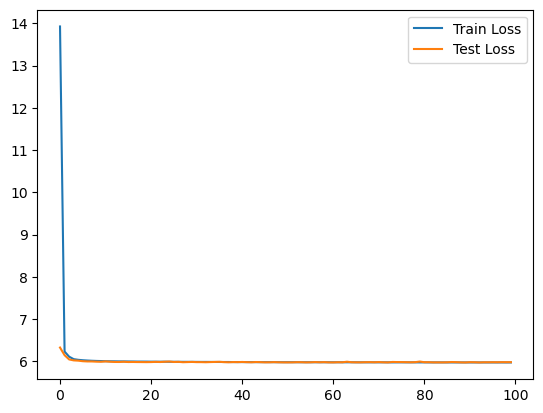

In [92]:
# Plot the training and testing losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()


### Extra credit:


1. Are there any predictors/features that have effectively no impact on the accuracy of these models? If so, please list them and comment briefly on your findings


In [98]:
import seaborn as sns

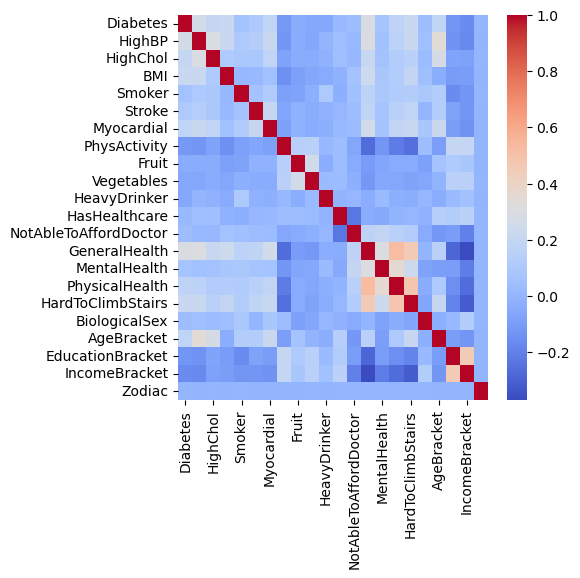

<Figure size 640x480 with 0 Axes>

In [110]:
# Calculate the correlation coefficients
corr = df.corr()
# Create the heatmap without displaying the coefficients
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=False, cmap='coolwarm')

# Show the plot
plt.show()
# save the plot as png file
plt.savefig('correlation_matrix.png', dpi=300)

In [97]:
# Calculate the correlation coefficients
correlations_bmi = df.corr()['BMI']

# Print the correlation coefficients
print(correlations)

Diabetes                 0.216843
HighBP                   0.213748
HighChol                 0.106722
BMI                      1.000000
Smoker                   0.013804
Stroke                   0.020153
Myocardial               0.052904
PhysActivity            -0.147294
Fruit                   -0.087518
Vegetables              -0.062275
HeavyDrinker            -0.048736
HasHealthcare           -0.018471
NotAbleToAffordDoctor    0.058206
GeneralHealth            0.239185
MentalHealth             0.085310
PhysicalHealth           0.121141
HardToClimbStairs        0.197078
BiologicalSex            0.042950
AgeBracket              -0.036618
EducationBracket        -0.103932
IncomeBracket           -0.100069
Zodiac                  -0.001932
Name: BMI, dtype: float64


In [103]:
# Calculate the correlation coefficients
correlations_db = df.corr()['Diabetes']

# Print the correlation coefficients
print(correlations_db)

Diabetes                 1.000000
HighBP                   0.263129
HighChol                 0.200276
BMI                      0.216843
Smoker                   0.060789
Stroke                   0.105816
Myocardial               0.177282
PhysActivity            -0.118133
Fruit                   -0.040779
Vegetables              -0.056584
HeavyDrinker            -0.057056
HasHealthcare            0.016255
NotAbleToAffordDoctor    0.031433
GeneralHealth            0.293569
MentalHealth             0.069315
PhysicalHealth           0.171337
HardToClimbStairs        0.218344
BiologicalSex            0.031430
AgeBracket               0.177442
EducationBracket        -0.124456
IncomeBracket           -0.163919
Zodiac                  -0.000197
Name: Diabetes, dtype: float64


2. Write a summary statement on the overall pros and cons of using neural networks to learn from the same dataset as in the prior homework, relative to using classical methods (logistic regression, SVM, trees, forests, boosting methods). Any overall lessons?